## Introduction
#### This notebook serves as the sandbox where the necessary scripting for creating a fasterRCNN model with CRES simulated data was figured out. It contains the first simulations with boundary box outputs, and the pytorch Dataset and DataModule needed to fit a small batch of the simulated data produced. Once it was demonstrated to be working to first order, the script `fasterRCNN_ds.py` was made in order to run the simulation from the command line for use in larger scale training. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
from pathlib import Path
import shutil
import json

sys.path.append(sys.path[0]+'/..')
from he6_cres_deep_learning.daq import DAQ, Config

## Creating Boundary Box outputs in a CRES simulation

#### Function to create the DataFrame of files/events and target boundary boxes

In [2]:
def fasterrcnn_df(n_files, n_events_per_file, spec_length=.035, freq_bw=1200e6, slope_mean=2e8, slope_std=1e7, seed=1234):
    '''
    Define the DataFrame describing the simulation of various events over several spec files. Entries are track-level description of
    the electron's motion in the CRES apparatus. As of now there are still unphysical aspects to the simulation, but the important piece 
    is the inclusion of the boundary boxes as an output.
    Returns a DataFrame of the track information and the boundary boxes in dictionary format. Also returns track-level boundary boxes for
    visualization and error-checking purposes.
    '''
    
    # Use the format first defined by Drew for structure of sim data
    track_set = {
            "file_in_acq": [],
            "event_num": [],
            "time_start": [],
            "time_stop": [],
            "freq_start": [],
            "freq_stop": [],
            "slope": [],
            "band_power_start": [],
            "band_power_stop": [],
            "band_num": [],
        }
    
    # Dictionary to store event boundary boxes for each file
    event_bboxes = {
        0: # key will be file number
            {0: # value will be a dict, where key is event number (this will grow through sim)
                 []} # value of the inner dict will be the boundary box coordinates 
                     # in format [start_time, start_freq, stop_time, stop_freq]
    }
    
    # Define Generator object for pulling from distributions
    rng = np.random.default_rng(seed)
    
    # n_events in a spec file can be reasonably estimated from a Poisson distribution
    n_events = rng.poisson(lam=3, size=n_files) 
    # don't want files with 0 events
    n_events += 1
    
    # Loop over files
    for file, events in enumerate(n_events): 
        # check if file in keys for bboxes, if not then initialize dict
        if file not in event_bboxes.keys():
            event_bboxes[file] = {0: []}

        # Pull from uniform distribution to determine start time of event
        event_start_times = rng.uniform(low=0, high=spec_length, size=events)
        
#-------------------------------------------------------------------------------------------------------------------------
        # Get start frequencies
        # TODO: implement beta spectrum sampling for start frequencies
        event_start_frequencies = rng.uniform(low=150e6, high=freq_bw, size=events)
#-------------------------------------------------------------------------------------------------------------------------

        # Loop over each event in file
        for event, (start_time, start_freq) in enumerate(zip(event_start_times, event_start_frequencies)):
            # check if event in keys for bboxes, if not then initialize list
            if event not in event_bboxes[file].keys():
                event_bboxes[file][event] = []
                
#-------------------------------------------------------------------------------------------------------------------------
            # Define number of scatters per event
            # TODO: Implement a physical model for scattering
            n_tracks = rng.integers(low=1, high = 10)
#-------------------------------------------------------------------------------------------------------------------------

            # Loop over each track in event
            for track in range(n_tracks):
                # Defining break parameter if need to leave loop because we hit edge of spec file
                _break = False
                
                # Pull track length from exponential distribution with tau=10ms
                track_len = rng.exponential(scale=.01)
                
                # Check to see if track outside of time window
                if start_time+track_len > spec_length:
                    stop_time = spec_length
                    track_len = spec_length-start_time
                    _break = True
                else:
                    stop_time = start_time+track_len
    
#-------------------------------------------------------------------------------------------------------------------------
                # Slope of track is assumed to be normally distributed around the mean of 2e8Hz in Kr83 events
                # TODO: Implement empirical model for track slopes based on energy of the electron
                slope = rng.normal(loc=slope_mean, scale=slope_std)
#-------------------------------------------------------------------------------------------------------------------------
                
                # Check if track outside of bandwidth
                if start_freq + slope*track_len > freq_bw:
                    stop_freq = freq_bw
                    _break = True
                else:
                    stop_freq = start_freq+slope*track_len

                # Store parameters in dict
                track_set["file_in_acq"].append(file)
                track_set["event_num"].append(event)
                track_set["time_start"].append(start_time)
                track_set["time_stop"].append(stop_time)
                track_set["slope"].append(slope)
                track_set["freq_start"].append(start_freq)
                track_set["freq_stop"].append(stop_freq)
                
                # If first track in event, add start_time, start_freq to bboxes dict
                if track==0:
                    event_bboxes[file][event].append(start_time)
                    event_bboxes[file][event].append(start_freq)
                
                # If hit edge then break out of track loop for this event, append bbox values
                if _break:
                    event_bboxes[file][event].append(stop_time)
                    event_bboxes[file][event].append(stop_freq)
                    break
                
                # If reached number of tracks in event then append bbox values
                elif track==n_tracks-1:
                    event_bboxes[file][event].append(stop_time)
                    event_bboxes[file][event].append(stop_freq)
                
#-------------------------------------------------------------------------------------------------------------------------
                # Else update start time and freq. 
                # Frequency jump will be pulled from normal dist mean 10MHZ std 2MHz
                # TODO: Frequency jumps will also have to be pulled from physical scattering model
                else:
                    start_time = stop_time
                    start_freq = stop_freq + rng.normal(loc=10e6, scale=2e6)
#-------------------------------------------------------------------------------------------------------------------------
    
#-------------------------------------------------------------------------------------------------------------------------   
    # TODO: implement proper power information
    track_set["band_power_start"] = [1e-14]*len(track_set["slope"])
    track_set["band_power_stop"] = [1e-14]*len(track_set["slope"])
    track_set["band_num"] = np.zeros(len(track_set["slope"]))
#-------------------------------------------------------------------------------------------------------------------------
    
    # convert track_set dict to DataFrame
    track_set = pd.DataFrame(track_set)
    
    # define track bbox DataFrame
    track_bboxes = track_set.loc[:,("file_in_acq", "event_num")].copy()
    bbox_list = []
    
    # define counter to keep up with total tracks for indexing
    tot_tracks=0
    for file in event_bboxes.keys():
        for event in event_bboxes[file].keys():
            n_tracks = track_set[(track_set["file_in_acq"]==file) &\
                                 (track_set["event_num"]==event)].shape[0]
            for track in range(n_tracks):
                bbox_list.append(event_bboxes[file][event])
                if track==n_tracks-1:
                    tot_tracks += n_tracks
                    
    track_bboxes['bbox'] = bbox_list

    return track_set, track_bboxes, event_bboxes

## EDA (sanity checking the simulation)

In [3]:
track_df, bboxes, bboxes_dict = fasterrcnn_df(1000,3)

In [4]:
track_df.head()

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.022446,0.024955,6.764829e+08,6.769901e+08,2.020995e+08,1.000000e-14,1.000000e-14,0.0
1,0,0,0.024955,0.035000,6.873712e+08,6.893707e+08,1.990581e+08,1.000000e-14,1.000000e-14,0.0
2,0,1,0.006399,0.023035,1.172086e+09,1.175451e+09,2.022679e+08,1.000000e-14,1.000000e-14,0.0
3,0,1,0.023035,0.027329,1.184342e+09,1.185237e+09,2.083806e+08,1.000000e-14,1.000000e-14,0.0
4,0,2,0.032537,0.035000,8.871375e+08,8.876496e+08,2.079502e+08,1.000000e-14,1.000000e-14,0.0


In [5]:
bboxes.head(5)

,file_in_acq,event_num,bbox
0,0,0,"[0.022445951135104024, 676482927.7811224, 0.03..."
1,0,0,"[0.022445951135104024, 676482927.7811224, 0.03..."
2,0,1,"[0.006398810424519579, 1172086133.3575711, 0.0..."
3,0,1,"[0.006398810424519579, 1172086133.3575711, 0.0..."
4,0,2,"[0.03253736927410235, 887137532.9909794, 0.035..."


#### Let's make sure the `file_in_acq` and `event_num` columns match

In [6]:
(track_df['file_in_acq'] != bboxes['file_in_acq']).sum(),\
(track_df['event_num'] != bboxes['event_num']).sum()

(0, 0)

#### Check that we are within the spectrogram limits provided as defaults

In [7]:
track_df['time_stop'].max(),track_df['freq_stop'].max()/1e6

(0.035, 1200.0)

#### Make sure distributions of the columns make sense

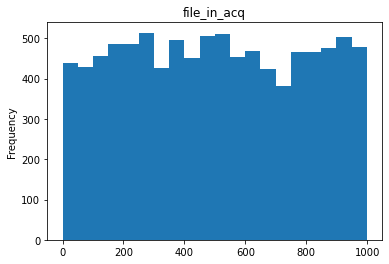

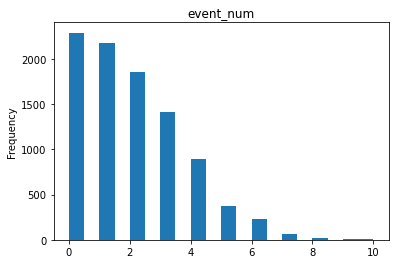

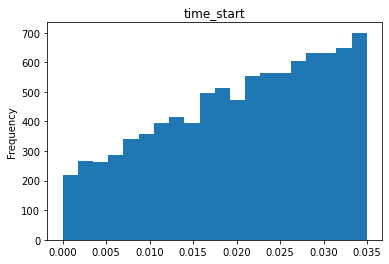

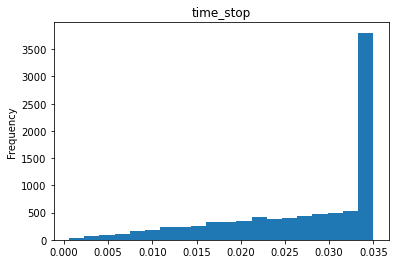

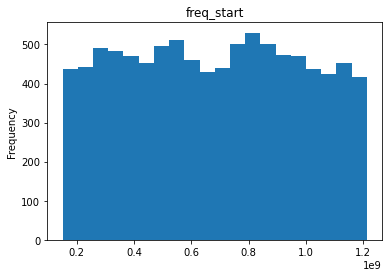

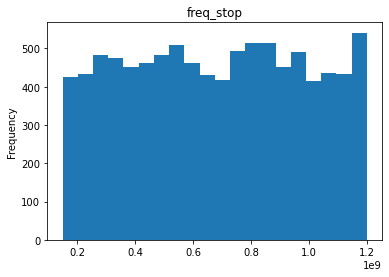

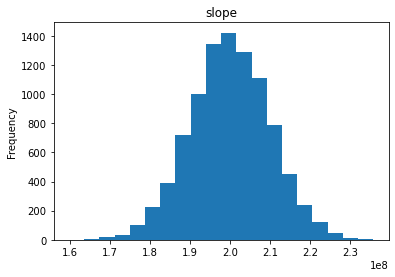

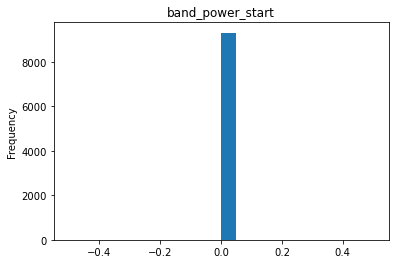

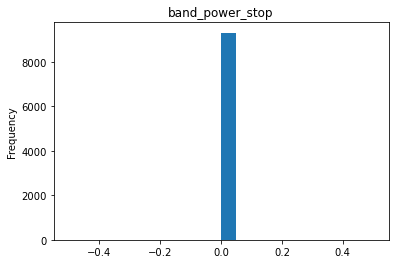

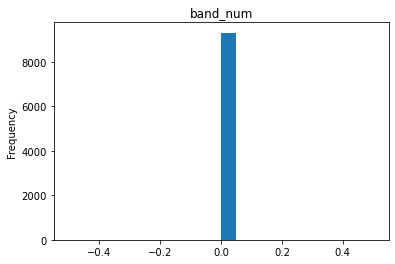

In [8]:
for column in track_df.columns:
    track_df[column].plot(kind='hist', title=column, bins=20)
    plt.show()

Everything looks good up to here. Note that the increasing trend in `time_start` and `time_stop` is reasonable because of scattering present in the simulation which defines the beginning of a new track.

### Plotting tracks and bboxes

In [9]:
def plot_tracks_and_bboxes(tracks, file_in_acq, freq_bw, bbox_list=[]):
    '''
    Given the tracks df and file number you wish to look at will plot the tracks in the file and optionally
    overlay the boundary boxes for the events.
    '''
    condition = tracks.file_in_acq == file_in_acq

    fig, ax = plt.subplots(figsize=(12, 8))

    for index, row in tracks[condition].iterrows():

        time_coor = np.array([row["time_start"], row["time_stop"]])
        freq_coor = np.array([row["freq_start"], row["freq_stop"]])

        ax.plot(
            time_coor,
            freq_coor,
            "ro-",
            markersize=0.5,
            alpha=0.5,
        )
    ax.set_ylim(0, freq_bw)
    ax.set_title("tracks")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Freq (Hz)")
    
    if len(bbox_list):
        bbox_list = bbox_list[bbox_list['file_in_acq']==file_in_acq]['bbox'].values
        for bbox in bbox_list:
            width = bbox[2]-bbox[0]
            height = bbox[3]-bbox[1]
            ax.add_patch(Rectangle(bbox[:2], width, height, alpha=.1))
    plt.show()

    return None

#### Define a random number to look at several files

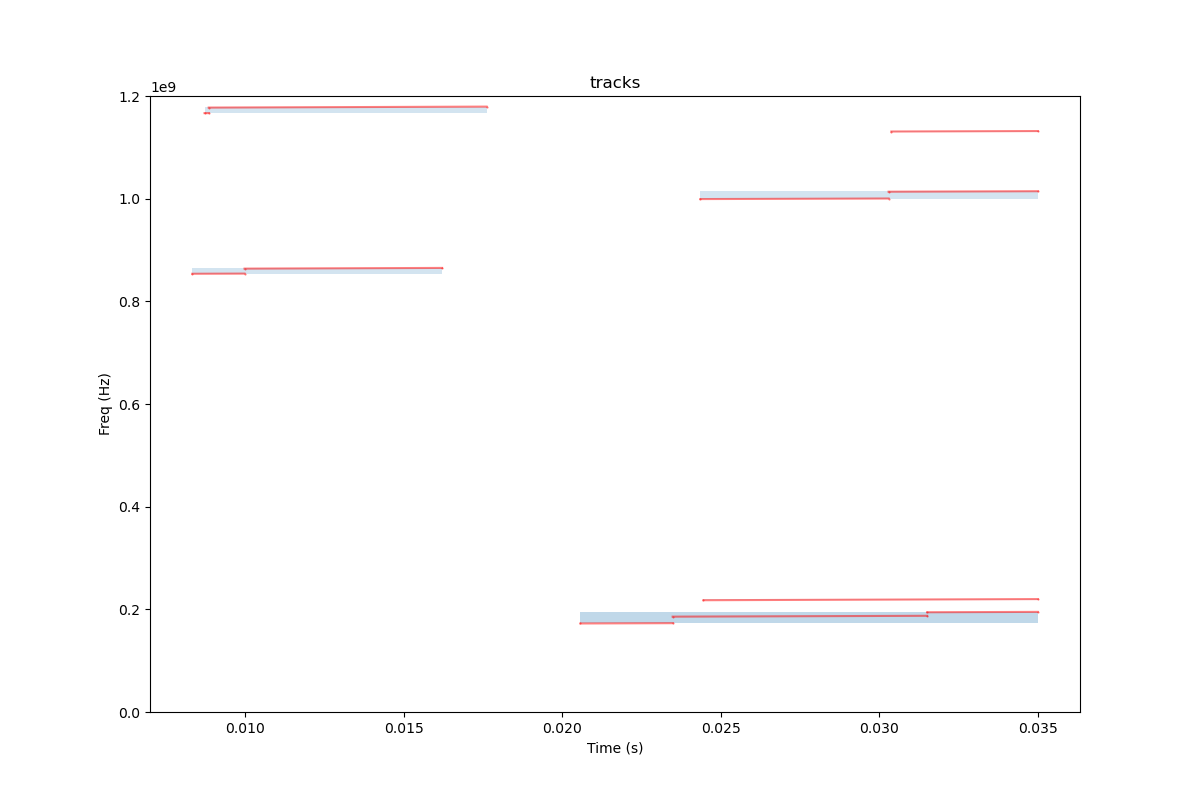

In [22]:
%matplotlib widget
rand_num = np.random.randint(low=1, high=1000)
plot_tracks_and_bboxes(track_df, rand_num, 1200e6, bboxes)

From what I've seen everything looks great!

## Spec file generation
#### Now the information in the track DataFrame will be passed on to the simulation that transforms it into the spectrogram image that is seen in the CRES experiment. Testing the output here to verify it works, as well as create the appropriate transformation for the boundary boxes. Replicating some of the functions from `daq.py` here for testing.

In [11]:
def congifure_gain_noise_csv_simple(csv_path):
    """
    Note that if you don't change the noise here you will end up with the default noise
    floor of the apparatus (I-side).
    """
    # Sinusoidal gain:
    col = "gain"

    array = np.array([1.0] * 4096)
    update_gain_noise_csv(csv_path, col, array)

    # Flat noise:
    col = "noise_mean"

    array = np.array([1.0] * 4096)

    update_gain_noise_csv(csv_path, col, array)

def update_gain_noise_csv(csv_path, col, array):
    """
    Helper function for editing gain_noise.csv.
    """
    noise_gain_df = pd.read_csv(csv_path)
    noise_gain_df[col] = array
    noise_gain_df.to_csv(csv_path, index=False)

    return None

#### sys.path[0] will always give the current directory, so base config paths will just be appended to this. 

In [12]:
base_path = sys.path[0]
# ---- Copy and rename base config ----
name = "fasterRCNN_test"
config_path = base_path + '/config/base_daq_config.yaml'
config_path = Path(config_path)
config_path_test = config_path.with_name(name + config_path.suffix)
shutil.copyfile(str(config_path), str(config_path_test))

'/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config/fasterRCNN_test.yaml'

In [13]:
# ---- Copy then alter base noise_gain file to make it simpler. ----
# Step 0: make a copy of the gain noise file.
gain_noise_path = base_path + '/gain_noise/base_gain_noise.csv'
gain_noise_path = Path(gain_noise_path)
gain_noise_path_test = gain_noise_path.with_name(
    gain_noise_path.stem + f"_{name}" + gain_noise_path.suffix
)
shutil.copyfile(str(gain_noise_path), str(gain_noise_path_test))

'/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/gain_noise/base_gain_noise_fasterRCNN_test.csv'

In [14]:
# Step 1: alter the gain_noise file.
congifure_gain_noise_csv_simple(gain_noise_path_test)

# ---- Build spec files ----
config = Config(config_path_test)
config.daq

{'spec_length': 0.035,
 'freq_bw': 1200000000.0,
 'freq_bins': 4096,
 'roach_avg': 2,
 'requant_gain': 20,
 'base_gain': 100000000000.0,
 'rng_seed': 123456,
 'build_labels': False,
 'waveguide_side"': 'I',
 'gain_noise_csv_path': '/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/demo/gain_noise/base_gain_noise.csv',
 'spec_prefix': 'test'}

In [15]:
# Change default settings of config to match input args.
config.daq.gain_noise_csv_path = gain_noise_path_test
config.daq.spec_length = 0.035
config.daq.spec_prefix = 'clean_test'
config.daq

{'spec_length': 0.035,
 'freq_bw': 1200000000.0,
 'freq_bins': 4096,
 'roach_avg': 2,
 'requant_gain': 20,
 'base_gain': 100000000000.0,
 'rng_seed': 123456,
 'build_labels': False,
 'waveguide_side"': 'I',
 'gain_noise_csv_path': PosixPath('/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/gain_noise/base_gain_noise_fasterRCNN_test.csv'),
 'spec_prefix': 'clean_test'}

In [16]:
# Extract necessary parameters from config.
spec_length = config.daq.spec_length
freq_bw = config.daq.freq_bw

# Build the track set to be simulated.
tracks, _, target_dict = fasterrcnn_df(
    n_files=5, n_events_per_file=3
)

tracks.head()

,file_in_acq,event_num,time_start,time_stop,freq_start,freq_stop,slope,band_power_start,band_power_stop,band_num
0,0,0,0.023929,0.035000,6.108992e+08,6.131420e+08,2.025884e+08,1.000000e-14,1.000000e-14,0.0
1,0,1,0.023493,0.031908,7.092248e+08,7.106981e+08,1.750821e+08,1.000000e-14,1.000000e-14,0.0
2,0,1,0.031908,0.035000,7.189449e+08,7.195236e+08,1.871687e+08,1.000000e-14,1.000000e-14,0.0
3,0,2,0.021386,0.023938,1.532889e+08,1.537930e+08,1.975278e+08,1.000000e-14,1.000000e-14,0.0
4,0,2,0.023938,0.035000,1.603936e+08,1.625729e+08,1.970036e+08,1.000000e-14,1.000000e-14,0.0


In [17]:
# Build the simulated spec files.
daq = DAQ(config)
daq.run(tracks)

/Users/winston/Documents/dsir-1031/projects/he6-cres-deep-learning/fasterRCNN/config
Building spec file 0. 0.035 s, 5126 slices.
file = 0, slices = [0:400]
file = 0, slices = [400:800]
file = 0, slices = [800:1200]
file = 0, slices = [1200:1600]
file = 0, slices = [1600:2000]
file = 0, slices = [2000:2400]
file = 0, slices = [2400:2800]
file = 0, slices = [2800:3200]
file = 0, slices = [3200:3600]
file = 0, slices = [3600:4000]
file = 0, slices = [4000:4400]
file = 0, slices = [4400:4800]
file = 0, slices = [4800:5126]
Time to build file 0: 18.573 s 

Building spec file 1. 0.035 s, 5126 slices.
file = 1, slices = [0:400]
file = 1, slices = [400:800]
file = 1, slices = [800:1200]
file = 1, slices = [1200:1600]
file = 1, slices = [1600:2000]
file = 1, slices = [2000:2400]
file = 1, slices = [2400:2800]
file = 1, slices = [2800:3200]
file = 1, slices = [3200:3600]
file = 1, slices = [3600:4000]
file = 1, slices = [4000:4400]
file = 1, slices = [4400:4800]
file = 1, slices = [4800:5126]
Ti

#### The DAQ ran and made some spec files. Let's make sure that the bboxes can be written to disk as well.

In [18]:
def write_label_files(target_dict, path_to_target_dir, spec_prefix):
    if not path_to_target_dir.is_dir():
        path_to_target_dir.mkdir()
        print("created directory : ", path_to_target_dir)
    with open(f'{path_to_target_dir}/{spec_prefix}_labels.json', 'w') as file:
        json.dump(target_dict, file)

In [19]:
labels_path = config_path.parent.joinpath(name, 'label_files')
write_label_files(target_dict, labels_path, config.daq.spec_prefix)

#### Ok, got some json files with bboxes. Let's check the spec files then move on.

In [20]:
spec_path = daq.spec_file_paths[0]
spec_array = daq.spec_to_array(spec_path, slices = -1)

(5126, 4096)


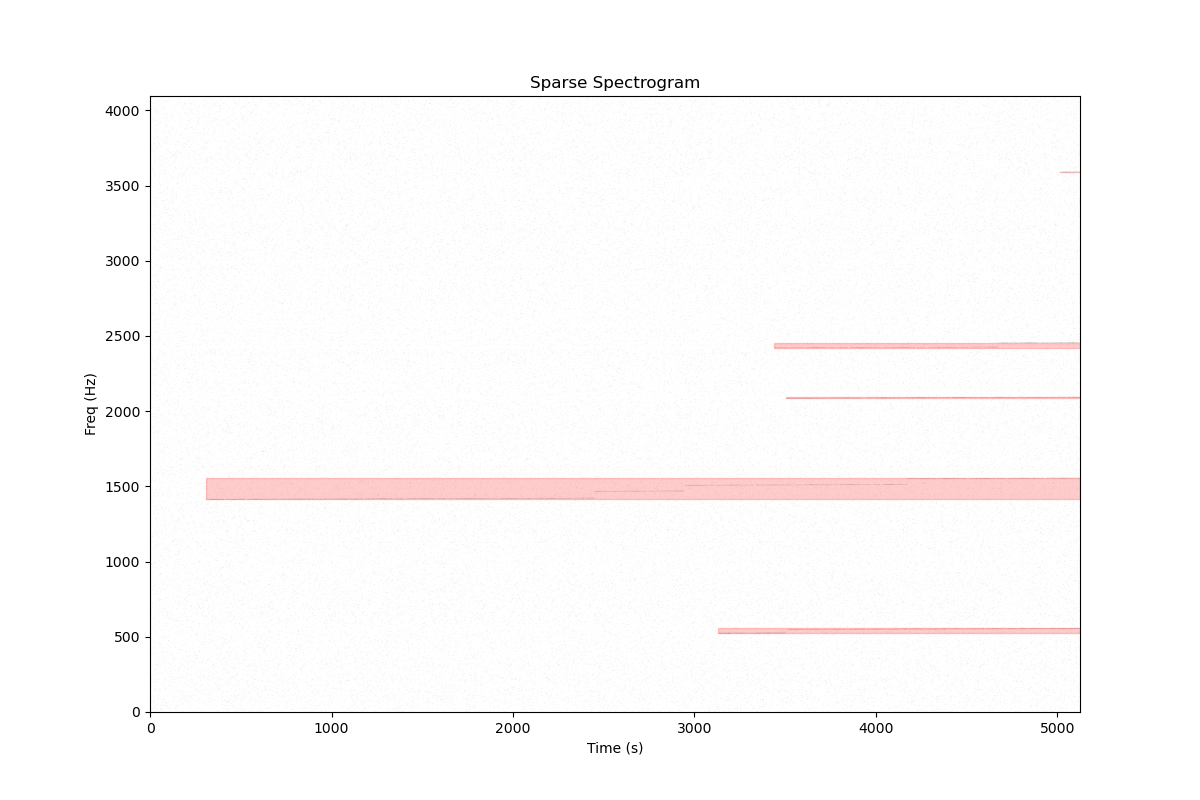

In [21]:
%matplotlib widget

cut_condition = np.array((spec_array > spec_array.mean(axis=0)*5).T , dtype = float)

fig, ax = plt.subplots(figsize=(12,8))

ax.imshow(1-cut_condition,origin='lower', aspect='auto', interpolation=None, cmap = "gray")

for bbox in target_dict[0].values():
    t1 = bbox[0] * config.daq.freq_bw / config.daq.freq_bins / config.daq.roach_avg
    f1 = bbox[1] *  config.daq.freq_bins/config.daq.freq_bw
    width = (bbox[2]-bbox[0]) * config.daq.freq_bw / config.daq.freq_bins / config.daq.roach_avg
    height = (bbox[3]-bbox[1]) * config.daq.freq_bins/config.daq.freq_bw
    ax.add_patch(Rectangle([t1,f1], width, height, alpha=.2, color='red'))

ax.set_title("Sparse Spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Freq (Hz)")
plt.show()

After having to do the annoying conversion to pixel width height for the bboxes, things are looking good. 

#### That will be all that is done in this notebook. I have adapted the simulation to the needs of the fasterRCNN model, and confirmed that it works in terms of producing the information I need. There is still much work to be done to get the modeling done, but that will be done in another notebook. I will produce a script based off the work in this notebook that will allow one to generate many spec files from the command line, which I will do on an AWS instance. Unfortunately, I will need to write the pixel-level information for the bboxes to disk, because after the simulation script is run the modeling won't necessarily have access to the full info. This will be done in the script `fasterRCNN_ds.py`.